Data 
    
    - Collected from weight.csv file and applied two columns( weighted_value, IsHS) only. 
    - Manipulated four models(Random-Forest, LogisticRegression,AdaBoostClassifier and KNeighborsClassifier)
    - Selected the best model to predict a label value whether a HS Comment or No HS Comment.
    - Calculated a confusion matrix (Accuracy, Precision,Recall, F1-Score). 


In [2]:
import pandas as pd
import numpy as np
from glob import glob 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import math 
import gspread 
import os 
from oauth2client.service_account import ServiceAccountCredentials

import pickle
import joblib

In [11]:
scope = ["https://spreadsheets.google.com/feeds", 'https://www.googleapis.com/auth/drive']

creds= ServiceAccountCredentials.from_json_keyfile_name('hs_data_sheet.json',scope)
client = gspread.authorize(creds)
HS_Accuracy =client.open('HS_Accuracy')

weighted_value_by_sentence = HS_Accuracy.get_worksheet(4)   #annotate_here

weighted_value_by_sentence_val=weighted_value_by_sentence.get_all_records()
weighted_value_by_sentence_list=[]
for index in range(len(weighted_value_by_sentence_val)):
    for key in weighted_value_by_sentence_val[index]:
        if key=='MsgUniSeg':
            MsgUniSeg_key=weighted_value_by_sentence_val[index][key]
        elif key=='Weighted_Value':
            Weighted_Value_key =weighted_value_by_sentence_val[index][key]
        elif key=='IsHS':
            IsHS=weighted_value_by_sentence_val[index][key]
        else:pass
    weighted_value_by_sentence_list.append([MsgUniSeg_key,Weighted_Value_key,IsHS])

#Create annotate_here dataframe 
weighted_val_new = pd.DataFrame(weighted_value_by_sentence_list, columns=['MsgUniSeg','Weighted_Value','IsHS'])


# Preprocessing Step

In [12]:
print(weighted_val_new.dtypes)

MsgUniSeg          object
Weighted_Value    float64
IsHS                int64
dtype: object


In [13]:
# Check missing values in a given dataset
weighted_val_new.isna().sum()

MsgUniSeg         130
Weighted_Value      0
IsHS                0
dtype: int64

In [14]:
weighted_val_new.shape

(15478, 3)

In [ ]:
weighted_val_updated =weighted_val_new.dropna()

In [ ]:
weighted_val_updated.isna().sum()

In [ ]:
weighted_val_updated.shape

In [ ]:
# Statistical summary of all attributes

statistical_summary = weighted_val_updated.describe()
statistical_summary

#### Here, maximum number of weighted_value is 3.642369 and minimum number of weighted_value is 0.0. 

In [10]:
weighted_val_updated.isna().sum()

MsgUniSeg         0
Weighted_Value    0
IsHS              0
dtype: int64

In [11]:
weighted_val_updated['IsHS'].value_counts()

0    12295
1     3053
Name: IsHS, dtype: int64

In [12]:
weighted_val_updated.columns

Index(['MsgUniSeg', 'Weighted_Value', 'IsHS'], dtype='object')

In [13]:
X=weighted_val_updated[['Weighted_Value']]

In [14]:
 weighted_val_updated['IsHS'].unique()

array([1, 0])

In [15]:
# y is a vector, hence we use dot to access 'label'
y = weighted_val_updated[['IsHS']]

In [16]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7,random_state=1)

In [17]:
## Apply RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
ytrain_pred = rf_model.predict_proba(X_train)
print('RF train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = (rf_model.predict_proba(X_test))
print('RF test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

RF train roc-auc: 0.8473086450164908
RF test roc-auc: 0.7170733946290926


In [18]:
log_classifier=LogisticRegression()
log_classifier.fit(X_train, y_train)
ytrain_pred = log_classifier.predict_proba(X_train)
print('Logistic train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = log_classifier.predict_proba(X_test)
print('Logistic test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

Logistic train roc-auc: 0.7480020527979637
Logistic test roc-auc: 0.7538142767634674


In [19]:
ada_classifier=AdaBoostClassifier()
ada_classifier.fit(X_train, y_train)
ytrain_pred = ada_classifier.predict_proba(X_train)
print('Adaboost train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = ada_classifier.predict_proba(X_test)
print('Adaboost test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

Adaboost train roc-auc: 0.7630779105253794
Adaboost test roc-auc: 0.7629647816520712


In [20]:
knn_classifier=KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
ytrain_pred = knn_classifier.predict_proba(X_train)
print('Adaboost train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = knn_classifier.predict_proba(X_test)
print('Adaboost test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

Adaboost train roc-auc: 0.7550729290689877
Adaboost test roc-auc: 0.6915114601698991


In [21]:
pred=[]
for model in [rf_model,log_classifier,ada_classifier,knn_classifier]:
    pred.append(pd.Series(model.predict_proba(X_test)[:,1]))
final_prediction=pd.concat(pred,axis=1).mean(axis=1)
print(' test roc-auc: {}'.format(roc_auc_score(y_test,final_prediction)))

 test roc-auc: 0.7508260356409099


In [22]:
pd.concat(pred,axis=1).mean(axis=1)

0       0.159251
1       0.159921
2       0.158895
3       0.363267
4       0.166276
          ...   
4600    0.390720
4601    0.288483
4602    0.177193
4603    0.166276
4604    0.372844
Length: 4605, dtype: float64

In [23]:
#### Calculate the ROc Curve
fpr, tpr, thresholds = roc_curve(y_test, final_prediction)
# thresholds

In [24]:
accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(final_prediction>thres,1,0)
    accuracy_ls.append(accuracy_score(y_test, y_pred, normalize=True))
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)],
                        axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head()

,thresholds,accuracy
85,0.545064,0.805863
87,0.544539,0.805863
84,0.547381,0.805646
83,0.548194,0.805646
86,0.545033,0.805646


In [25]:
# print the first predicted probabilities of class membership
y_pred_class =(rf_model.predict_proba(X_test)[:,1] >=0.3).astype(bool)

In [26]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(confusion)

#[row, column]
TP = confusion[1, 1]  
TN = confusion[0, 0] 
FP = confusion[0, 1] 
FN = confusion[1, 0]  


[[3110  560]
 [ 487  448]]


In [27]:
# use float to perform true division, not integer division
Accuracy =(TP + TN) / float(TP + TN + FP + FN)

print("Accuracy  :  ",Accuracy)
print("Accuracy  :  ",metrics.accuracy_score(y_test, y_pred_class))

Accuracy  :   0.7726384364820847
Accuracy  :   0.7726384364820847


In [28]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)

print(classification_error)
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.2273615635179153
0.22736156351791525


In [29]:
sensitivity_recall = TP / float(FN + TP)   # True Positive Rate


print("Recall           : ",sensitivity_recall)

print("Metric Recall    : ",metrics.recall_score(y_test, y_pred_class))

Recall           :  0.47914438502673795
Metric Recall    :  0.47914438502673795


In [30]:
specificity = TN / (TN + FP)  

print(specificity)

0.8474114441416893


In [31]:
false_positive_rate = FP / float(TN + FP)   # False Positive Rate

print(false_positive_rate)
print(1 - specificity)

0.15258855585831063
0.15258855585831066


In [32]:
precision = TP / float(TP + FP)

print(precision)
print(metrics.precision_score(y_test, y_pred_class))

0.4444444444444444
0.4444444444444444


In [33]:
F1=2*((precision*sensitivity_recall)/(precision+sensitivity_recall))


In [34]:
print("Accuracy     :   ",Accuracy)
print("Precision    :   ",precision)
print("Recall       :   ",sensitivity_recall)
print("F1 Score     :   ",F1)

Accuracy     :    0.7726384364820847
Precision    :    0.4444444444444444
Recall       :    0.47914438502673795
F1 Score     :    0.46114256304683476


In [35]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

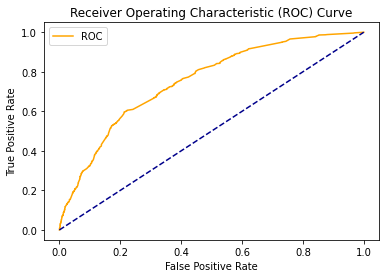

In [36]:
plot_roc_curve(fpr,tpr)

In [37]:
from sklearn.metrics import precision_recall_fscore_support as score

In [38]:
y_pred = rf_model.predict(X_test)

# print the first predicted probabilities of class membership
y_pred_class =(rf_model.predict_proba(X_test)[:,1] >=0.3).astype(bool)


precision, recall,fscore,support = score(y_test,y_pred_class,pos_label=1,average='binary')

print('Precision : {} / Recall : {}  / F1 Score : {}'.format(round(precision,3),round(recall,3),round(fscore,3)))

Precision : 0.444 / Recall : 0.479  / F1 Score : 0.461


In [39]:
model_Name = 'final_sentence_lex_train.pkl'
joblib.dump(model,model_Name)

['final_sentence_lex_train.pkl']

In [40]:
# load the model from disk

loaded_model = joblib.load(model_Name)
result = loaded_model.score(X_test,y_test)
print(result)

0.7806731813246471


In [41]:
#make a prediction
X_test_input =[[1.321],[0.212],[1.2321],[3.01231],[1.4526],[0.544]]

ynew =rf_model.predict(X_test_input)
ynew

array([1, 0, 0, 0, 1, 0])